# Speech-to-Intent Pipeline with PyTorch

This notebook implements a complete pipeline for Speech-to-Intent recognition using a local dataset.
It includes:
1.  **Audio Preprocessing**: Resampling, Mono conversion, Normalization.
2.  **EDA**: Class distribution, Duration analysis, Spectrograms.
3.  **Data Splitting**: Train/Val/Test.
4.  **Models**:
    *   **ASR**: Fine-tuning Wav2Vec2 (Audio -> Text).
    *   **Intent**: Fine-tuning DistilBERT (Text -> Intent).
5.  **Training**: Custom PyTorch training loops.
6.  **Evaluation**: Accuracy, Confusion Matrix, Visualizations.
7.  **Saving**: Saving models for deployment.

In [1]:
# 1. Import Libraries and Set Device

# Fix DNS resolution issues (forces IPv4 to avoid Python DNS bugs on Windows)
import socket
_original_getaddrinfo = socket.getaddrinfo
def getaddrinfo_ipv4_only(*args, **kwargs):
    responses = _original_getaddrinfo(*args, **kwargs)
    return [r for r in responses if r[0] == socket.AF_INET]
socket.getaddrinfo = getaddrinfo_ipv4_only

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm.notebook import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("DNS fix applied: Using IPv4 addresses only.")

Using device: cuda
DNS fix applied: Using IPv4 addresses only.


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [3]:
# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()

In [4]:
# 2. Configuration and Metadata Loading
DATASET_PATH = r"D:\PROJET_ROPOTIQUE\robot_voice_dataset"
AUDIO_DIR = os.path.join(DATASET_PATH, "audio")
METADATA_PATH = os.path.join(DATASET_PATH, "metadata.csv")

# Load Metadata
if not os.path.exists(METADATA_PATH):
    raise FileNotFoundError(f"Metadata file not found at {METADATA_PATH}")

df = pd.read_csv(METADATA_PATH)

# Fix column names: Code expects 'intent', CSV has 'label'
if 'label' in df.columns and 'intent' not in df.columns:
    df = df.rename(columns={'label': 'intent'})

print(f"Dataset loaded. Total samples: {len(df)}")
print("Columns:", df.columns.tolist())
display(df.head())

# Verify audio files exist
# Note: 'file' column in CSV already includes 'audio/' prefix (e.g., 'audio/filename.wav')
# So we join with DATASET_PATH, not AUDIO_DIR
# We use os.path.normpath to ensure Windows-style backslashes are consistent
df['path'] = df['file'].apply(lambda x: os.path.normpath(os.path.join(DATASET_PATH, x)))

missing_files = df[~df['path'].apply(os.path.exists)]
if not missing_files.empty:
    print(f"Warning: {len(missing_files)} audio files are missing.")
    print(f"Example missing path: {missing_files.iloc[0]['path']}")
    df = df[df['path'].apply(os.path.exists)]
else:
    print("All audio files verified.")
    print(f"Example valid path: {df.iloc[0]['path']}")

Dataset loaded. Total samples: 80
Columns: ['file', 'text', 'intent']


,file,text,intent
0,audio/avance_01.wav,avance,AVANCER
1,audio/avance_02.wav,avance,AVANCER
2,audio/avance_03.wav,avance,AVANCER
3,audio/avance_04.wav,avance,AVANCER
4,audio/avance_05.wav,avance,AVANCER


All audio files verified.
Example valid path: D:\PROJET_ROPOTIQUE\robot_voice_dataset\audio\avance_01.wav


In [5]:
# 3. Audio Preprocessing Functions
import imageio_ffmpeg
import subprocess
import io
import soundfile as sf
import warnings

TARGET_SR = 16000

def load_audio_fallback(file_path, target_sr):
    """
    Fallback loader using direct FFmpeg subprocess.
    Converts audio to WAV (PCM) in memory and loads with soundfile.
    This bypasses librosa's backend detection which can be flaky with MP3-in-WAV files on Windows.
    """
    try:
        ffmpeg_exe = imageio_ffmpeg.get_ffmpeg_exe()
        # Convert to WAV, mono, target_sr, output to stdout
        cmd = [
            ffmpeg_exe,
            '-y',             # overwrite (not needed for pipe but good habit)
            '-i', file_path,
            '-f', 'wav',      # force wav format
            '-ac', '1',       # mono
            '-ar', str(target_sr), # sample rate
            '-'               # stdout
        ]
        
        # Run ffmpeg, capture stdout. Suppress stderr to avoid log spam.
        wav_data = subprocess.check_output(cmd, stderr=subprocess.DEVNULL)
        
        # Load with soundfile
        y, sr = sf.read(io.BytesIO(wav_data))
        y = y.astype(np.float32) # Ensure float32 for consistency with librosa
        return y, sr
    except Exception as e:
        # If fallback also fails, we really can't load this file
        # print(f"Fallback loader failed for {os.path.basename(file_path)}: {e}")
        return None, None

def preprocess_audio(file_path):
    """
    Loads audio, converts to mono, resamples to 16kHz, 
    normalizes amplitude.
    """
    y = None
    sr = None
    
    # 1. Try loading with librosa (standard way)
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y, sr = librosa.load(file_path, sr=TARGET_SR, mono=True)
    except Exception:
        # 2. If librosa fails (e.g. NoBackendError or LibsndfileError), try fallback
        y, sr = load_audio_fallback(file_path, TARGET_SR)
        
    if y is None:
        print(f"Failed to load: {os.path.basename(file_path)}")
        return None, None

    # Amplitude Normalization
    if np.max(np.abs(y)) > 0:
        y = y / np.max(np.abs(y))
        
    return y, sr

# Test on one file
sample_file = df.iloc[0]['path']
print(f"Testing preprocessing on: {sample_file}")
y, sr = preprocess_audio(sample_file)

if y is not None:
    print(f"Processed sample shape: {y.shape}, SR: {sr}")
else:
    print("Failed to process sample file.")


Testing preprocessing on: D:\PROJET_ROPOTIQUE\robot_voice_dataset\audio\avance_01.wav
Processed sample shape: (25941,), SR: 16000


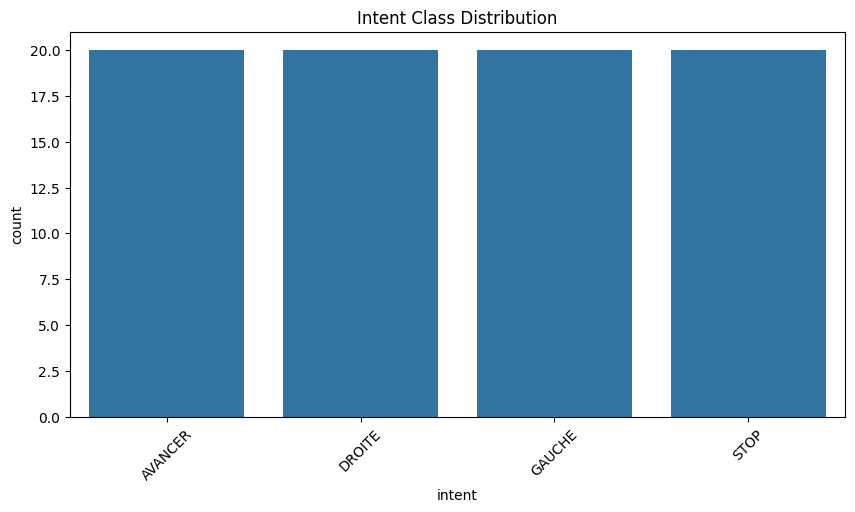

Starting duration analysis...


Calculating durations:   0%|          | 0/80 [00:00<?, ?it/s]

Successfully loaded 80/80 files.


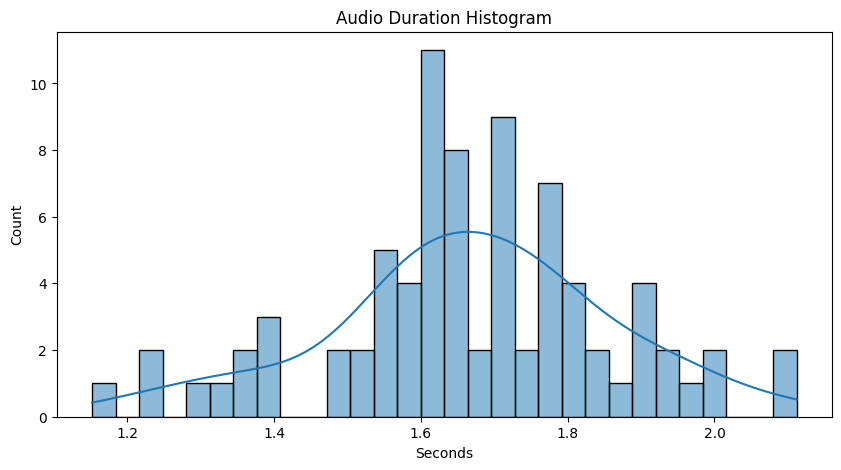

Mean duration: 1.67s
Max duration: 2.11s
Plotting spectrograms for intents: ['AVANCER' 'DROITE' 'GAUCHE' 'STOP']


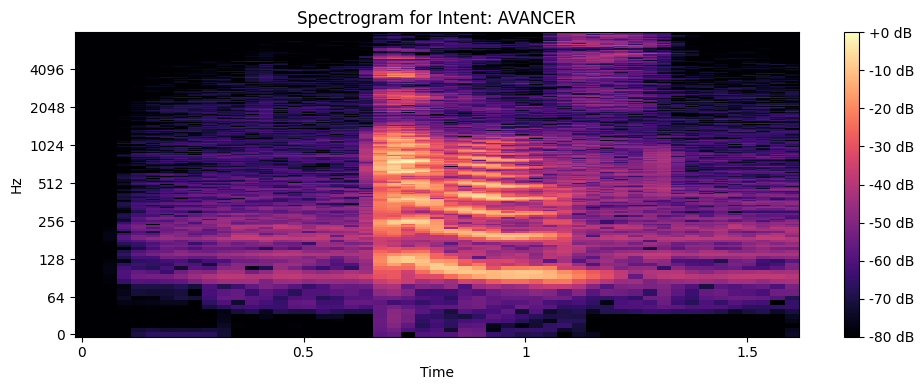

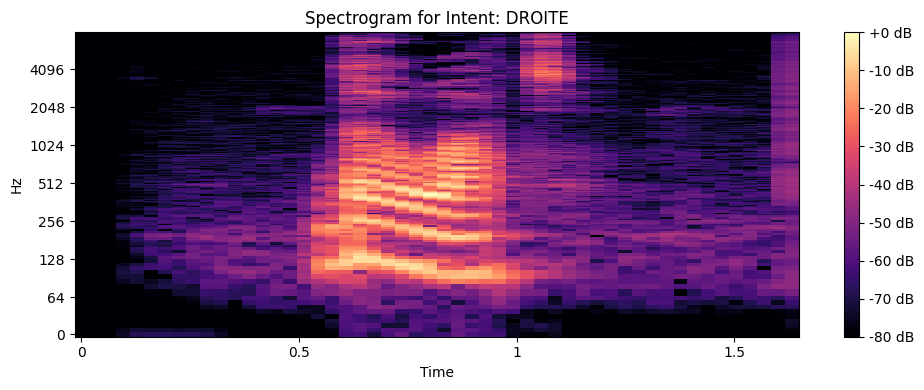

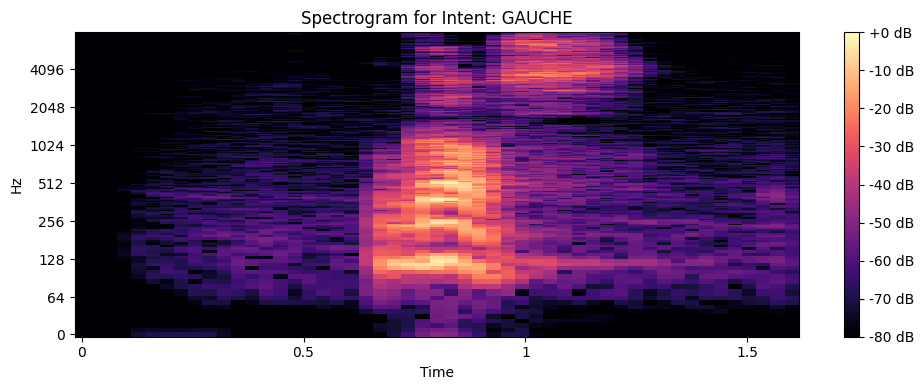

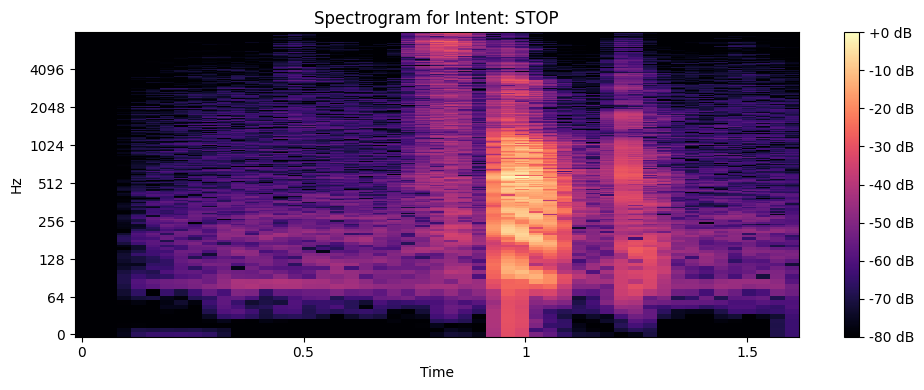

In [6]:
# 4. Exploratory Data Analysis (EDA)
import struct

# 4.1 Class Distribution
plt.figure(figsize=(10, 5))
sns.countplot(x='intent', data=df)
plt.title("Intent Class Distribution")
plt.xticks(rotation=45)
plt.show()

# 4.2 Audio Duration Analysis
durations = []
valid_indices = []

print("Starting duration analysis...")

for idx, path in tqdm(enumerate(df['path']), total=len(df), desc="Calculating durations"):
    # Use the robust preprocessor defined in Step 3
    # This handles the MP3-as-WAV issue via FFmpeg fallback
    y, sr = preprocess_audio(path)
    
    if y is not None:
        durations.append(librosa.get_duration(y=y, sr=sr))
        valid_indices.append(idx)

if valid_indices:
    # Update df to keep only valid files
    print(f"Successfully loaded {len(valid_indices)}/{len(df)} files.")
    df = df.iloc[valid_indices].reset_index(drop=True)
    df['duration'] = durations

    plt.figure(figsize=(10, 5))
    sns.histplot(df['duration'], bins=30, kde=True)
    plt.title("Audio Duration Histogram")
    plt.xlabel("Seconds")
    plt.show()

    print(f"Mean duration: {np.mean(durations):.2f}s")
    print(f"Max duration: {np.max(durations):.2f}s")
    
    # 4.3 Spectrograms
    def plot_spectrogram(y, sr, title):
        plt.figure(figsize=(10, 4))
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()
        plt.show()

     # Plot examples for ALL unique intents (including STOP)
    unique_intents = df['intent'].unique()
    print(f"Plotting spectrograms for intents: {unique_intents}")
    
    for intent in unique_intents:
        subset = df[df['intent'] == intent]
        if not subset.empty:
            sample = subset.iloc[0]
            y, sr = preprocess_audio(sample['path'])
            if y is not None:
                plot_spectrogram(y, sr, f"Spectrogram for Intent: {intent}")
else:
    print("CRITICAL: No audio files could be loaded. Please check the dataset files.")


In [7]:
# 5. Dataset Splitting
# We need to map intents to IDs
intents = df['intent'].unique().tolist()
intent2id = {intent: i for i, intent in enumerate(intents)}
id2intent = {i: intent for i, intent in enumerate(intents)}
num_labels = len(intents)

print(f"Intents: {intent2id}")

# Split: Train (70%), Val (15%), Test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['intent'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['intent'], random_state=42)

print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")


Intents: {'AVANCER': 0, 'DROITE': 1, 'GAUCHE': 2, 'STOP': 3}
Train size: 56
Val size: 12
Test size: 12


In [8]:
# 6. Custom Dataset & DataLoaders
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*as_target_processor.*")

# Initialize Processors
# Use a French-compatible model for better ASR performance
# 'facebook/wav2vec2-large-xlsr-53-french' is a strong choice for French
MODEL_ID = "facebook/wav2vec2-large-xlsr-53-french"

print(f"Loading processor from {MODEL_ID}...")
asr_processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
# Intent Tokenizer (DistilBERT Multilingual for French support)
intent_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

class SpeechIntentDataset(Dataset):
    def __init__(self, dataframe, asr_processor, intent_tokenizer, intent2id):
        self.data = dataframe.reset_index(drop=True)
        self.asr_processor = asr_processor
        self.intent_tokenizer = intent_tokenizer
        self.intent2id = intent2id
        self.target_sr = 16000

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        audio_path = row['path']
        text = row['text']
        intent = row['intent']

        # 1. Process Audio
        y, sr = preprocess_audio(audio_path)
        
        if y is None:
            return None

        # Pad/Truncate
        audio_inputs = self.asr_processor(y, sampling_rate=self.target_sr, return_tensors="pt").input_values
        audio_inputs = audio_inputs.squeeze(0)

        # 2. Process Text (Labels for ASR)
        # Use the updated API
        asr_labels = self.asr_processor(text=text, return_tensors="pt").input_ids.squeeze(0)

        # 3. Process Intent (Labels for Classifier)
        text_inputs = self.intent_tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=64)
        input_ids = text_inputs['input_ids'].squeeze(0)
        attention_mask = text_inputs['attention_mask'].squeeze(0)
        intent_label = torch.tensor(self.intent2id[intent], dtype=torch.long)

        return {
            "input_values": audio_inputs,
            "asr_labels": asr_labels,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "intent_label": intent_label,
            "text": text
        }

# Custom Collator
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None

    input_values = [item['input_values'] for item in batch]
    asr_labels = [item['asr_labels'] for item in batch]
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    intent_labels = torch.stack([item['intent_label'] for item in batch])
    texts = [item['text'] for item in batch]

    input_values_padded = torch.nn.utils.rnn.pad_sequence(input_values, batch_first=True)
    asr_labels_padded = torch.nn.utils.rnn.pad_sequence(asr_labels, batch_first=True, padding_value=-100)

    return {
        "input_values": input_values_padded,
        "asr_labels": asr_labels_padded,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "intent_labels": intent_labels,
        "texts": texts
    }

# Create DataLoaders
train_dataset = SpeechIntentDataset(train_df, asr_processor, intent_tokenizer, intent2id)
val_dataset = SpeechIntentDataset(val_df, asr_processor, intent_tokenizer, intent2id)
test_dataset = SpeechIntentDataset(test_df, asr_processor, intent_tokenizer, intent2id)

BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

print("DataLoaders ready with French model.")

Loading processor from facebook/wav2vec2-large-xlsr-53-french...
DataLoaders ready with French model.


In [9]:
# 7. Initialize Models
from transformers import logging as transformers_logging

transformers_logging.set_verbosity_error()

# 7.1 ASR Model (Wav2Vec2)
# Use the same French model ID as the processor
MODEL_ID = "facebook/wav2vec2-large-xlsr-53-french"

print(f"Loading ASR model from {MODEL_ID}...")
asr_model = Wav2Vec2ForCTC.from_pretrained(
    MODEL_ID, 
    ctc_loss_reduction="mean", 
    pad_token_id=asr_processor.tokenizer.pad_token_id
)
asr_model.freeze_feature_encoder()
asr_model.to(device)

# 7.2 Intent Model (DistilBERT Multilingual)
# Use multilingual model to handle French text better
intent_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=num_labels
)
intent_model.to(device)

print("Models initialized.")

Loading ASR model from facebook/wav2vec2-large-xlsr-53-french...


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rahli\.cache\huggingface\hub\models--facebook--wav2vec2-large-xlsr-53-french. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

c:\Users\rahli\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rahli\.cache\huggingface\hub\models--distilbert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Models initialized.


In [10]:
# 8. Training Loop 1: ASR Fine-tuning (Audio -> Text)

# Lower learning rate slightly for fine-tuning a large model
asr_optimizer = AdamW(asr_model.parameters(), lr=5e-5)
# Increase epochs significantly to allow convergence on small data
asr_epochs = 15 

print(f"Starting ASR Fine-tuning for {asr_epochs} epochs...")
asr_losses = []

for epoch in range(asr_epochs):
    asr_model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"ASR Epoch {epoch+1}/{asr_epochs}")
    
    for batch in progress_bar:
        if batch is None:
            continue

        input_values = batch['input_values'].to(device)
        labels = batch['asr_labels'].to(device)
        
        asr_optimizer.zero_grad()
        
        outputs = asr_model(input_values, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        asr_optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    avg_loss = epoch_loss / len(train_loader)
    asr_losses.append(avg_loss)
    print(f"Epoch {epoch+1} ASR Loss: {avg_loss:.4f}")

print("ASR Training Complete.")


Starting ASR Fine-tuning for 15 epochs...


ASR Epoch 1/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 ASR Loss: 1.0134


ASR Epoch 2/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2 ASR Loss: 0.4608


ASR Epoch 3/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3 ASR Loss: 0.2788


ASR Epoch 4/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4 ASR Loss: 0.2270


ASR Epoch 5/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5 ASR Loss: 0.2818


ASR Epoch 6/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6 ASR Loss: 0.2730


ASR Epoch 7/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7 ASR Loss: 0.2189


ASR Epoch 8/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8 ASR Loss: 0.2591


ASR Epoch 9/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9 ASR Loss: 0.2518


ASR Epoch 10/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10 ASR Loss: 0.1882


ASR Epoch 11/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11 ASR Loss: 0.1709


ASR Epoch 12/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12 ASR Loss: 0.1960


ASR Epoch 13/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13 ASR Loss: 0.1486


ASR Epoch 14/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14 ASR Loss: 0.0882


ASR Epoch 15/15:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15 ASR Loss: 0.1701
ASR Training Complete.


In [11]:
# 9. Training Loop 2: Intent Classification Fine-tuning (Text -> Intent)

intent_optimizer = AdamW(intent_model.parameters(), lr=5e-5)
intent_epochs = 10  # Increased epochs for better convergence

print(f"Starting Intent Classification Fine-tuning for {intent_epochs} epochs...")
intent_train_losses = []
intent_val_accuracies = []

for epoch in range(intent_epochs):
    # Training
    intent_model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Intent Epoch {epoch+1}/{intent_epochs}")
    
    for batch in progress_bar:
        if batch is None:
            continue

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['intent_labels'].to(device)
        
        intent_optimizer.zero_grad()
        
        outputs = intent_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        intent_optimizer.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    avg_loss = epoch_loss / len(train_loader)
    intent_train_losses.append(avg_loss)
    
    # Validation
    intent_model.eval()
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for batch in val_loader:
            if batch is None:
                continue

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['intent_labels'].to(device)
            
            outputs = intent_model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())
            
    val_acc = accuracy_score(val_labels, val_preds)
    intent_val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1} Intent Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Intent Training Complete.")

Starting Intent Classification Fine-tuning for 10 epochs...


Intent Epoch 1/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 Intent Loss: 1.0646, Val Acc: 1.0000


Intent Epoch 2/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2 Intent Loss: 0.2998, Val Acc: 1.0000


Intent Epoch 3/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3 Intent Loss: 0.0819, Val Acc: 1.0000


Intent Epoch 4/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4 Intent Loss: 0.0359, Val Acc: 1.0000


Intent Epoch 5/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5 Intent Loss: 0.0234, Val Acc: 1.0000


Intent Epoch 6/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6 Intent Loss: 0.0172, Val Acc: 1.0000


Intent Epoch 7/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7 Intent Loss: 0.0129, Val Acc: 1.0000


Intent Epoch 8/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8 Intent Loss: 0.0106, Val Acc: 1.0000


Intent Epoch 9/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9 Intent Loss: 0.0091, Val Acc: 1.0000


Intent Epoch 10/10:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10 Intent Loss: 0.0075, Val Acc: 1.0000
Intent Training Complete.


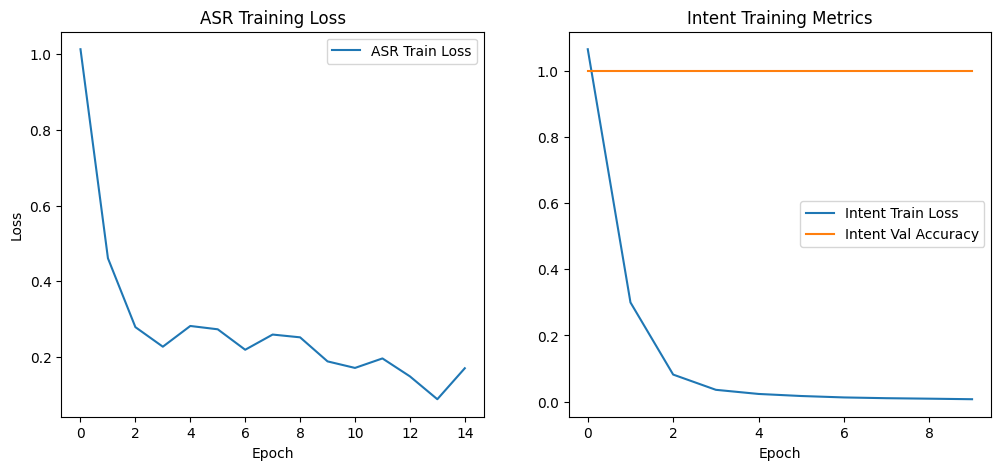

Evaluating Full Pipeline on Test Set...


Testing:   0%|          | 0/3 [00:00<?, ?it/s]


Full Pipeline Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

     AVANCER       1.00      1.00      1.00         3
      DROITE       1.00      1.00      1.00         3
      GAUCHE       1.00      1.00      1.00         3
        STOP       1.00      1.00      1.00         3

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12



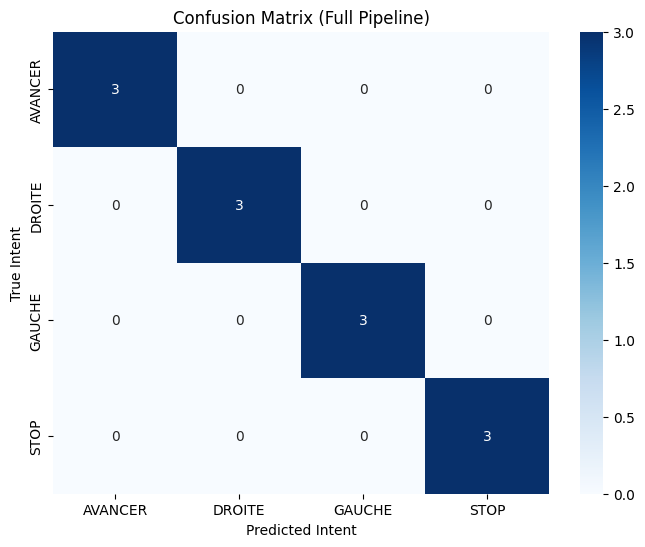


Sample Predictions (Random 10):
Sample 0:
  Predicted Text: avance
  Predicted Intent: AVANCER
  True Intent:      AVANCER
------------------------------
Sample 11:
  Predicted Text: stop
  Predicted Intent: STOP
  True Intent:      STOP
------------------------------
Sample 8:
  Predicted Text: droite
  Predicted Intent: DROITE
  True Intent:      DROITE
------------------------------
Sample 9:
  Predicted Text: gauche
  Predicted Intent: GAUCHE
  True Intent:      GAUCHE
------------------------------
Sample 5:
  Predicted Text: stop
  Predicted Intent: STOP
  True Intent:      STOP
------------------------------
Sample 1:
  Predicted Text: stop
  Predicted Intent: STOP
  True Intent:      STOP
------------------------------
Sample 10:
  Predicted Text: avance
  Predicted Intent: AVANCER
  True Intent:      AVANCER
------------------------------
Sample 2:
  Predicted Text: gauche
  Predicted Intent: GAUCHE
  True Intent:      GAUCHE
------------------------------
Sample 4:
  Predict

In [12]:
# 10. Evaluation & Visualization
import random

# 10.1 Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(asr_losses, label='ASR Train Loss')
plt.title("ASR Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(intent_train_losses, label='Intent Train Loss')
plt.plot(intent_val_accuracies, label='Intent Val Accuracy') # Scale might be different
plt.title("Intent Training Metrics")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# 10.2 Full Pipeline Evaluation on Test Set
print("Evaluating Full Pipeline on Test Set...")
asr_model.eval()
intent_model.eval()

all_true_intents = []
all_pred_intents = []
all_transcriptions = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        if batch is None:
            continue

        # 1. ASR Inference (Audio -> Text)
        input_values = batch['input_values'].to(device)
        
        # Forward pass ASR
        logits = asr_model(input_values).logits
        pred_ids = torch.argmax(logits, dim=-1)
        
        # Decode predicted text
        pred_texts = asr_processor.batch_decode(pred_ids)
        all_transcriptions.extend(pred_texts)
        
        # 2. Intent Inference (Predicted Text -> Intent)
        # We must re-tokenize the PREDICTED text for the intent model
        # This tests the robustness of the intent model to ASR errors
        encoded_preds = intent_tokenizer(
            pred_texts, 
            return_tensors="pt", 
            padding="max_length", 
            truncation=True, 
            max_length=64
        )
        
        input_ids = encoded_preds['input_ids'].to(device)
        attention_mask = encoded_preds['attention_mask'].to(device)
        
        intent_outputs = intent_model(input_ids=input_ids, attention_mask=attention_mask)
        intent_preds = torch.argmax(intent_outputs.logits, dim=1)
        
        all_pred_intents.extend(intent_preds.cpu().numpy())
        all_true_intents.extend(batch['intent_labels'].cpu().numpy())

# 10.3 Metrics
if all_true_intents:
    acc = accuracy_score(all_true_intents, all_pred_intents)
    print(f"\nFull Pipeline Accuracy: {acc:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_true_intents, all_pred_intents, target_names=intents))

    # 10.4 Confusion Matrix
    cm = confusion_matrix(all_true_intents, all_pred_intents)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=intents, yticklabels=intents)
    plt.title("Confusion Matrix (Full Pipeline)")
    plt.xlabel("Predicted Intent")
    plt.ylabel("True Intent")
    plt.show()

    # 10.5 Sample Predictions
    print("\nSample Predictions (Random 10):")
    num_samples = min(10, len(all_transcriptions))
    indices = random.sample(range(len(all_transcriptions)), num_samples)
    
    for i in indices:
        print(f"Sample {i}:")
        print(f"  Predicted Text: {all_transcriptions[i]}")
        print(f"  Predicted Intent: {id2intent[all_pred_intents[i]]}")
        print(f"  True Intent:      {id2intent[all_true_intents[i]]}")
        print("-" * 30)
else:
    print("No valid test samples found.")

In [13]:

# 11. Save Models
SAVE_DIR = os.path.join(DATASET_PATH, "models")
os.makedirs(SAVE_DIR, exist_ok=True)

# Save ASR
asr_save_path = os.path.join(SAVE_DIR, "asr_model")
asr_model.save_pretrained(asr_save_path)
asr_processor.save_pretrained(asr_save_path)
print(f"ASR Model saved to {asr_save_path}")

# Save Intent
intent_save_path = os.path.join(SAVE_DIR, "intent_model")
intent_model.save_pretrained(intent_save_path)
intent_tokenizer.save_pretrained(intent_save_path)
print(f"Intent Model saved to {intent_save_path}")

print("All steps completed successfully.")


ASR Model saved to D:\PROJET_ROPOTIQUE\robot_voice_dataset\models\asr_model
Intent Model saved to D:\PROJET_ROPOTIQUE\robot_voice_dataset\models\intent_model
All steps completed successfully.
